### Loading and prerequesites

In [1]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
VARIANT = "FULL" # "SMALL", "MEDIUM" , "FULL"

if VARIANT == "SMALL":
    df = pd.read_pickle("../Data/df.pkl")
    df = df.head(30)
elif VARIANT == "MEDIUM":
    df = pd.read_pickle("../Data/df.pkl")
    df = df.head(500)
else:
    df = pd.read_pickle("../Data/df.pkl")

### General overview over the dataset

In [3]:
df

,nexis_id,title,publication_date,publication_year,publisher,text
0,5MNMH621JB0GF09H0000000,Angst vor dem «harten Brexit» auf der Insel - ...,2017-01-15,2017,AP Deutsch,Wenn Großbritannien Ende März den Ausstieg aus...
1,5SM3THB1DXFJ50MP0000000,Fleischindustrie wehrt sich gegen Marketing fü...,2018-06-21,2018,AP Deutsch,Fleisch aus dem Labor ist noch eine Zukunftsvi...
2,5SM3THB1DXFJ50MY0000000,Der AP-Überblick am Nachmittag,2018-06-21,2018,AP Deutsch,Die AP Weltnachrichten haben heute unter ander...
3,5STNVWH1DXFJ53VM0000000,Laborfleisch soll in drei Jahren auf die Telle...,2018-07-17,2018,AP Deutsch,Maastricht (AP) - Das niederländische Unterneh...
4,5VHK2XG1JB0GF4Y50000000,Israelische Forscher wollen künstliche Steaks ...,2019-02-26,2019,AP Deutsch,"Die Weltbevölkerung wächst, die Nachfrage nach..."
...,...,...,...,...,...,...
5420,67KW1VK1F15WB4660000000,Kein Titel,2023-02-21,2023,ZEIT Wissen,6 Am anfang drei Fragen 1. Können wir andere m...
5421,67KW1VK1F15WB46B0000000,Leben und schmecken lassen,2023-02-21,2023,ZEIT Wissen,"Ein saftiges Filet, für das kein Huhn sterben ..."
5422,7W29GN20YC2460S30000000,ABSCHIED VOM ALTEN ITALIEN,2009-05-13,2009,ZEIT Wissen,John Dickie: »Delizia! Die Italiener und ihre...
5423,7X8DW4712SK2G0H10000000,Essen aus dem Labor,2009-12-08,2009,ZEIT Wissen,Es ist der letzte Tag auf der Lebensmittelmess...


In [4]:
print("First Textual Overview of the Dataset:")
print("------------------------")
print("First Publication Year:", df['publication_date'].min().year)
print("Last Publication Year:", df['publication_date'].max().year)
print("Total Number of Publications:", len(df))
print("\nNumber of Publications per Year:")
print(df['publication_year'].value_counts().sort_index())
print("\nNumber of Publications per Publisher:")
print(df['publisher'].value_counts())

First Textual Overview of the Dataset:
------------------------
First Publication Year: 1992
Last Publication Year: 2023
Total Number of Publications: 5425

Number of Publications per Year:
publication_year
1992      3
1993      6
1994     18
1995     20
1996     29
1997     49
1998     61
1999     98
2000    100
2001     66
2002     69
2003    151
2004    324
2005    191
2006    149
2007    129
2008    159
2009    141
2010     96
2011    105
2012    127
2013    155
2014    239
2015    203
2016    226
2017    136
2018    282
2019    256
2020    211
2021    351
2022    367
2023    908
Name: count, dtype: int64

Number of Publications per Publisher:
publisher
taz, die tageszeitung              428
Lebensmittel Zeitung               371
dpa-AFX ProFeed                    183
Frankfurter Rundschau              180
Stuttgarter Zeitung                179
                                  ... 
Logistik Heute                       1
TVEyes - BBC 1 Northern Ireland      1
TVEyes - BBC 1 East Mi

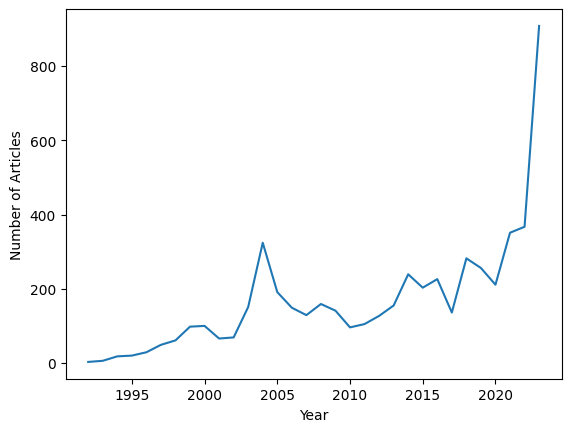

In [5]:
# Overview over yearly publications
df['publication_year'].value_counts().sort_index().plot(legend = None)
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.savefig('../Visuals/number_of_articles_per_year.png')
plt.show()

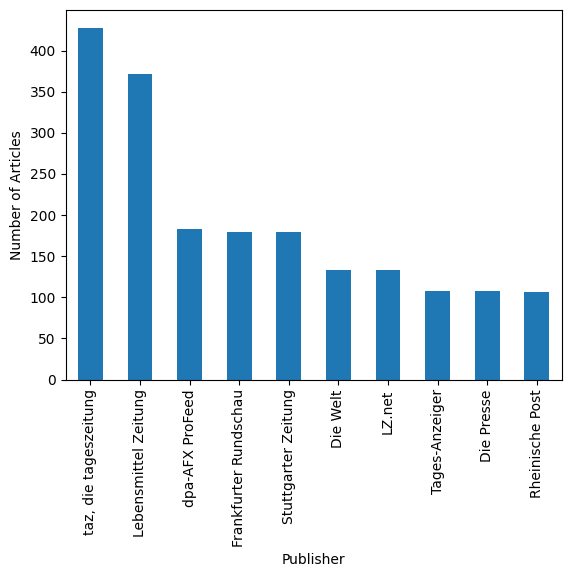

In [6]:
# Overview over publishers with most publicaations
df['publisher'].value_counts().nlargest(10).plot(legend = None, kind='bar',)
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.savefig('../Visuals/top_10_publishers.png')
plt.show()

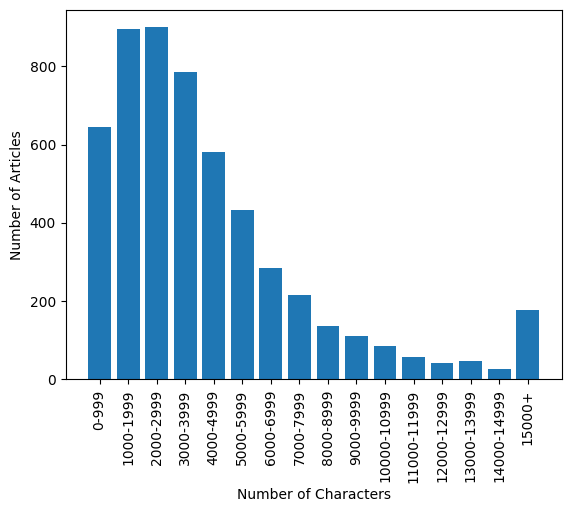

In [7]:
# Overview over articles length
# Define the intervals
intervals = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, float('inf')]

# Group the articles based on length intervals
grouped_articles = df.groupby(pd.cut(df['text'].str.len(), intervals)).size()

# Plot the bar plot
plt.bar(range(len(grouped_articles)), grouped_articles)

# Set the x-axis labels
plt.xticks(range(len(grouped_articles)), [f'{int(x.left)}-{int(x.right-1)}' if x.right != float('inf') else f'{int(x.left)}+' for x in grouped_articles.index], rotation=90)

# Set the x-axis label
plt.xlabel('Number of Characters')

# Set the y-axis label
plt.ylabel('Number of Articles')

# Save the plot
plt.savefig('../Visuals/articles_grouped_by_length.png')

# Show the plot
plt.show()

### SpaCy Initialisation

In [8]:
nlp = spacy.load("de_core_news_sm")

In [9]:
df

,nexis_id,title,publication_date,publication_year,publisher,text
0,5MNMH621JB0GF09H0000000,Angst vor dem «harten Brexit» auf der Insel - ...,2017-01-15,2017,AP Deutsch,Wenn Großbritannien Ende März den Ausstieg aus...
1,5SM3THB1DXFJ50MP0000000,Fleischindustrie wehrt sich gegen Marketing fü...,2018-06-21,2018,AP Deutsch,Fleisch aus dem Labor ist noch eine Zukunftsvi...
2,5SM3THB1DXFJ50MY0000000,Der AP-Überblick am Nachmittag,2018-06-21,2018,AP Deutsch,Die AP Weltnachrichten haben heute unter ander...
3,5STNVWH1DXFJ53VM0000000,Laborfleisch soll in drei Jahren auf die Telle...,2018-07-17,2018,AP Deutsch,Maastricht (AP) - Das niederländische Unterneh...
4,5VHK2XG1JB0GF4Y50000000,Israelische Forscher wollen künstliche Steaks ...,2019-02-26,2019,AP Deutsch,"Die Weltbevölkerung wächst, die Nachfrage nach..."
...,...,...,...,...,...,...
5420,67KW1VK1F15WB4660000000,Kein Titel,2023-02-21,2023,ZEIT Wissen,6 Am anfang drei Fragen 1. Können wir andere m...
5421,67KW1VK1F15WB46B0000000,Leben und schmecken lassen,2023-02-21,2023,ZEIT Wissen,"Ein saftiges Filet, für das kein Huhn sterben ..."
5422,7W29GN20YC2460S30000000,ABSCHIED VOM ALTEN ITALIEN,2009-05-13,2009,ZEIT Wissen,John Dickie: »Delizia! Die Italiener und ihre...
5423,7X8DW4712SK2G0H10000000,Essen aus dem Labor,2009-12-08,2009,ZEIT Wissen,Es ist der letzte Tag auf der Lebensmittelmess...


### Questions

In [10]:
def count_questions(text):
    doc = nlp(text)
    return sum(1 for sent in doc.sents if sent.text.strip().endswith('?'))

In [11]:
df['questions_count'] = df['text'].apply(count_questions)

In [12]:
df
df_sorted = df.sort_values(by='questions_count', ascending=False)
df_sorted

,nexis_id,title,publication_date,publication_year,publisher,text,questions_count
1778,5WYPY101F07YK18P0000000,Das neue Fleisch,2019-08-31,2019,Focus Magazin,Text von Corinna Baier und Elisabeth Krafft Se...,71
2544,3TF04P7000DBC38T0000000,None,2023-08-10,2023,Lebensmittel Zeitung,LZ: Unser heutiges Thema ist brandaktuell und ...,68
283,4G9T7VX0TWX282W70000000,"Cornflakes classic, Cornflakes mit Schoko und ...",2000-08-26,2000,None,"Von Bohlen: Lassen Sie die Tür ruhig offen, ic...",46
1773,5SXKHVS1F07YK01S0000000,Schöpfung auf Speed,2018-07-28,2018,Focus Magazin,"Text von Aleksandra Janevska, Kurt-Martin Maye...",42
4338,67DH39P1JC8114CH0000000,"Vegan, aber ?Fleischerei??",2023-01-27,2023,Sächsische Zeitung Regionalausgaben,Schnitzel- und Fleischkäsebrötchen auf die Han...,41
...,...,...,...,...,...,...,...
3037,4C3BBW0001NRM15H0000000,None,2023-08-10,2023,manager magazin online,Berlin - Der Bundesrat hat mit seiner Unionsme...,0
3038,4KWB1SM0TXFCB2940000000,Unheil auf dem Beilagenteller,2006-09-12,2006,manager magazin online,Als wäre Gammelfleisch nicht unappetitlich gen...,0
1286,4DYV78T0TWCNH2PD0000000,Gentechnik-Gesetz bringt Industrie in Aufruhr ...,2004-12-05,2004,Welt am Sonntag,"Für Hans Kast, Geschäftsführer der BASF Plant ...",0
3040,516W8CS1JCN120C50000000,Nestlés Traumweg zum Pillenkonzern,2010-10-11,2010,manager magazin online,Nestlé-Chef Peter Brabeck-Lethmate will die Re...,0


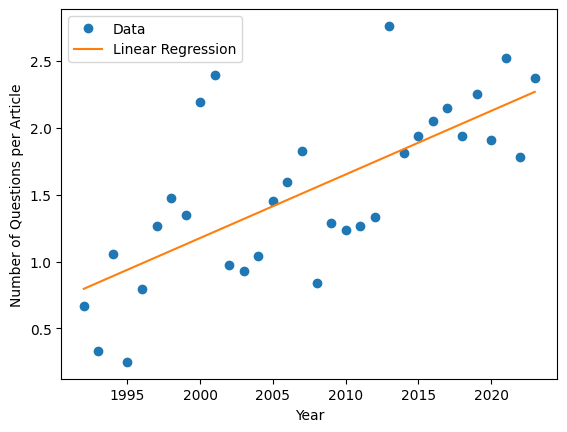

In [14]:
# Visualize the number of questions per article per year and fit a linear regression curve to the data
# Group by year and calculate the total number of questions and total number of articles for each year
df_grouped = df.groupby('publication_year').agg({'questions_count': 'sum', 'text': 'count'})

# Calculate the ratio of questions to total articles for each year
df_grouped['questions_ratio'] = df_grouped['questions_count'] / df_grouped['text']

# Fit a linear regression curve to the data
polynomial = np.poly1d(np.polyfit(df_grouped.index, df_grouped['questions_ratio'], 1))

# Generate x values for the curve
x = np.linspace(df_grouped.index.min(), df_grouped.index.max(), 100)

# Plot the data points and the polynomial curve
plt.plot(df_grouped.index, df_grouped['questions_ratio'], 'o', label='Data')
plt.plot(x, polynomial(x), label='Linear Regression')

# Set the x-axis label
plt.xlabel('Year')

# Set the y-axis label
plt.ylabel('Number of Questions per Article')

# Add a legend
plt.legend()

# Save the plot
plt.savefig('../Visuals/questions_ratio.png')

# Show the plot
plt.show()

### Pronouns

In [15]:
nlp = spacy.load("de_core_news_sm")
df["spacy_sm"] = df["text"].apply(lambda x: nlp(x))

In [16]:
du_variants = ["Du", "du", "Dich", "dich," "Dein", "dein", "Deine", "deine", "Deines" , "deines", "Deiner", "deiner", "Dir", "dir"]
ihr_variants = ["Ihr", "ihr", "Euch", "euch", "Euer", "euer", "Ihre", "ihre"]

In [17]:
df["count_du"] = 0
df["count_ihr"] = 0
df["count_du_ihr"] = 0

for index in df.index:
    du = 0
    ihr = 0
    for token in df["spacy_sm"][index]:
        if token.text in du_variants:
            du += 1
        if token.text in ihr_variants:
            ihr += 1
    df.loc[index, "count_du"] = du
    df.loc[index, "count_ihr"] = ihr
    du_ihr = du + ihr
    df.loc[index, "count_du_ihr"] = du_ihr

In [18]:
df

,nexis_id,title,publication_date,publication_year,publisher,text,questions_count,spacy_sm,count_du,count_ihr,count_du_ihr
0,5MNMH621JB0GF09H0000000,Angst vor dem «harten Brexit» auf der Insel - ...,2017-01-15,2017,AP Deutsch,Wenn Großbritannien Ende März den Ausstieg aus...,1,"(Wenn, Großbritannien, Ende, März, den, Aussti...",0,2,2
1,5SM3THB1DXFJ50MP0000000,Fleischindustrie wehrt sich gegen Marketing fü...,2018-06-21,2018,AP Deutsch,Fleisch aus dem Labor ist noch eine Zukunftsvi...,0,"(Fleisch, aus, dem, Labor, ist, noch, eine, Zu...",0,1,1
2,5SM3THB1DXFJ50MY0000000,Der AP-Überblick am Nachmittag,2018-06-21,2018,AP Deutsch,Die AP Weltnachrichten haben heute unter ander...,0,"(Die, AP, Weltnachrichten, haben, heute, unter...",0,2,2
3,5STNVWH1DXFJ53VM0000000,Laborfleisch soll in drei Jahren auf die Telle...,2018-07-17,2018,AP Deutsch,Maastricht (AP) - Das niederländische Unterneh...,0,"(Maastricht, (, AP, ), -, Das, niederländische...",0,0,0
4,5VHK2XG1JB0GF4Y50000000,Israelische Forscher wollen künstliche Steaks ...,2019-02-26,2019,AP Deutsch,"Die Weltbevölkerung wächst, die Nachfrage nach...",0,"(Die, Weltbevölkerung, wächst, ,, die, Nachfra...",0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
5420,67KW1VK1F15WB4660000000,Kein Titel,2023-02-21,2023,ZEIT Wissen,6 Am anfang drei Fragen 1. Können wir andere m...,12,"(6, Am, anfang, drei, Fragen, 1., Können, wir,...",1,0,1
5421,67KW1VK1F15WB46B0000000,Leben und schmecken lassen,2023-02-21,2023,ZEIT Wissen,"Ein saftiges Filet, für das kein Huhn sterben ...",0,"(Ein, saftiges, Filet, ,, für, das, kein, Huhn...",0,0,0
5422,7W29GN20YC2460S30000000,ABSCHIED VOM ALTEN ITALIEN,2009-05-13,2009,ZEIT Wissen,John Dickie: »Delizia! Die Italiener und ihre...,2,"(John, Dickie, :, », Delizia, !, Die, Italiene...",0,3,3
5423,7X8DW4712SK2G0H10000000,Essen aus dem Labor,2009-12-08,2009,ZEIT Wissen,Es ist der letzte Tag auf der Lebensmittelmess...,8,"(Es, ist, der, letzte, Tag, auf, der, Lebensmi...",0,6,6


In [19]:
years = []
for i in range(1992, 2024):
    years.append(i)

In [20]:
df_yearly_overview = pd.DataFrame(years, columns=["year"])
df_yearly_overview["publication_count"] = 0
df_yearly_overview["count_du"] = 0
df_yearly_overview["count_ihr"] = 0
df_yearly_overview["count_du_ihr"] = 0
df_yearly_overview.set_index("year", inplace=True)

# Fill the dataframe with the data
for index in df.index:
    year = df["publication_year"][index]
    df_yearly_overview.loc[year, "publication_count"] += 1
    df_yearly_overview.loc[year, "count_du"] += df["count_du"][index]
    df_yearly_overview.loc[year, "count_ihr"] += df["count_ihr"][index]
    df_yearly_overview.loc[year, "count_du_ihr"] += df["count_du_ihr"][index]

In [21]:
df_yearly_overview

,publication_count,count_du,count_ihr,count_du_ihr
year,,,,
1992,3,0,2,2
1993,6,0,8,8
1994,18,0,33,33
1995,20,2,12,14
1996,29,0,14,14
1997,49,0,50,50
1998,61,16,61,77
1999,98,4,129,133
2000,100,5,146,151


In [22]:
df_yearly_overview["count_du_per_publication"] = 0.0
df_yearly_overview["count_ihr_per_publication"] = 0.0
df_yearly_overview["count_du_ihr_per_publication"] = 0.0

In [23]:
index_list = df_yearly_overview.index.to_list()
for i in index_list:
    df_yearly_overview.loc[i, "count_du_per_publication"] = df_yearly_overview.loc[i, "count_du"] / df_yearly_overview.loc[i, "publication_count"]
    df_yearly_overview.loc[i, "count_ihr_per_publication"] = df_yearly_overview.loc[i, "count_ihr"] / df_yearly_overview.loc[i, "publication_count"]
    df_yearly_overview.loc[i, "count_du_ihr_per_publication"] = df_yearly_overview.loc[i, "count_du_ihr"] / df_yearly_overview.loc[i, "publication_count"]

In [24]:
df_yearly_overview

,publication_count,count_du,count_ihr,count_du_ihr,count_du_per_publication,count_ihr_per_publication,count_du_ihr_per_publication
year,,,,,,,
1992,3,0,2,2,0.000000,0.666667,0.666667
1993,6,0,8,8,0.000000,1.333333,1.333333
1994,18,0,33,33,0.000000,1.833333,1.833333
1995,20,2,12,14,0.100000,0.600000,0.700000
1996,29,0,14,14,0.000000,0.482759,0.482759
1997,49,0,50,50,0.000000,1.020408,1.020408
1998,61,16,61,77,0.262295,1.000000,1.262295
1999,98,4,129,133,0.040816,1.316327,1.357143
2000,100,5,146,151,0.050000,1.460000,1.510000


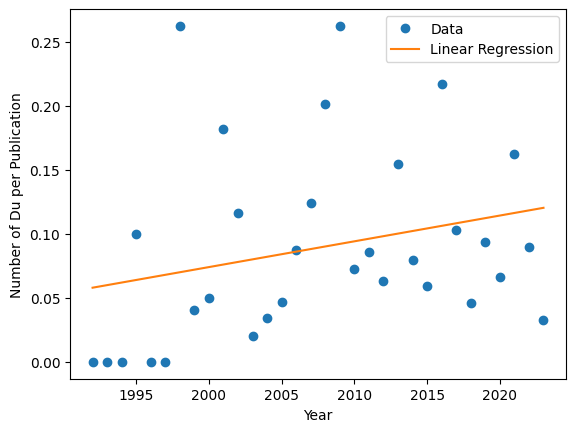

In [25]:
# Visualize the data of 'Du' per publication
# Fit a linear regression curve to the data
coefficients = np.polyfit(df_yearly_overview.index, df_yearly_overview['count_du_per_publication'], 1)
polynomial = np.poly1d(coefficients)

# Generate x values for the curve
x = np.linspace(df_yearly_overview.index.min(), df_yearly_overview.index.max(), 100)

# Plot the data points and the polynomial curve 
plt.plot(df_yearly_overview.index, df_yearly_overview['count_du_per_publication'], 'o', label='Data')
plt.plot(x, polynomial(x), label='Linear Regression')

# Set the x-axis label
plt.xlabel('Year')

# Set the y-axis label
plt.ylabel('Number of Du per Publication')

# Add a legend
plt.legend()

# Save the plot
plt.savefig('../Visuals/count_du_per_publication.png')

# Show the plot
plt.show()

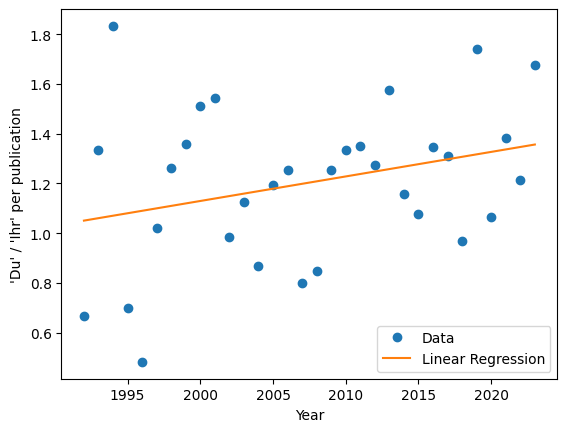

In [27]:
# Visualize the combined data of 'Du' and 'Ihr' per publication
# Fit a 1st-degree polynomial curve to the data
coefficients = np.polyfit(df_yearly_overview.index, df_yearly_overview['count_du_ihr_per_publication'], 1)
polynomial = np.poly1d(coefficients)

# Generate x values for the curve
x = np.linspace(df_yearly_overview.index.min(), df_yearly_overview.index.max(), 100)

# Plot the data points and the polynomial curve
plt.plot(df_yearly_overview.index, df_yearly_overview['count_du_ihr_per_publication'], 'o', label='Data')
plt.plot(x, polynomial(x), label='Linear Regression')

# Set the x-axis label
plt.xlabel('Year')

# Set the y-axis label
plt.ylabel('\'Du\' / \'Ihr\' per publication')

# Add a legend
plt.legend()

# Save the plot
plt.savefig('../Visuals/count_du_ihr_per_publication.png')

# Show the plot
plt.show()